## Import Libraries

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.pipeline import make_pipeline

import lightgbm as lgb
import xgboost as xgb

import featuretools as ft

from mlxtend.classifier import StackingClassifier

import gc
import time

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


from google.colab import drive
drive.mount('/content/drive')

## Load Data

In [0]:
filepath = '/content/drive/My Drive/Colab Notebooks/'
train_identity = pd.read_csv(filepath + 'train_identity.csv')
train_trans = pd.read_csv(filepath + 'train_transaction.csv')

test_identity = pd.read_csv(filepath + 'test_identity.csv')
test_trans = pd.read_csv(filepath + 'test_transaction.csv')
 
sample_sub= pd.read_csv(filepath + 'sample_submission.csv')

In [14]:
print(f'train_identity: {train_identity.shape}')
print(f'train_transaction: {train_trans.shape}')
print(f'test_identity: {test_identity.shape}')
print(f'test_transaction: {test_trans.shape}')

train_identity: (144233, 41)
train_transaction: (590540, 394)
test_identity: (141907, 41)
test_transaction: (506691, 393)


In [0]:
train = pd.merge(train_trans, train_identity, on='TransactionID', how='left')
test = pd.merge(test_trans, test_identity, on='TransactionID', how='left')

In [0]:
# Release memory
del train_identity, train_trans, test_identity, test_trans

## EDA

,0,1
isFraud,0.96501,0.03499


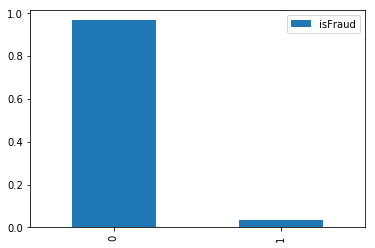

In [17]:
# Percentage of fraud vs. non-fraud
fc = train['isFraud'].value_counts(normalize=True).to_frame()
fc.plot.bar()
fc.T

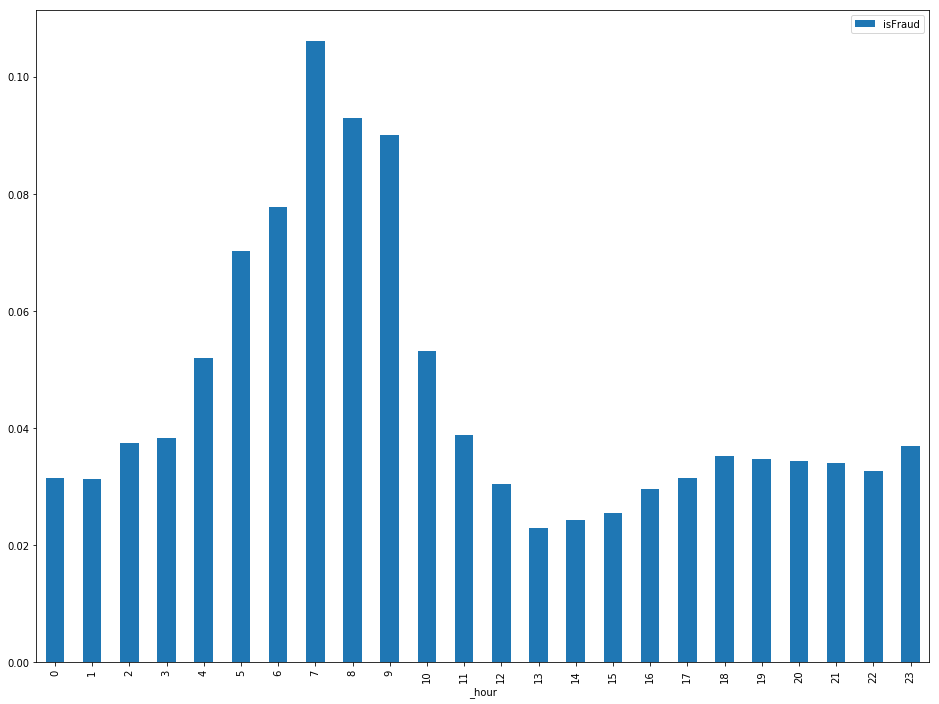

In [18]:
import datetime

START_DATE = '2017-11-30'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train['Date'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
train['_ymd'] = train['Date'].dt.year.astype(str) + '-' + train['Date'].dt.month.astype(str) + '-' + train['Date'].dt.day.astype(str)
train['_year_month'] = train['Date'].dt.year.astype(str) + '-' + train['Date'].dt.month.astype(str)
train['_weekday'] = train['Date'].dt.dayofweek
train['_hour'] = train['Date'].dt.hour
train['_day'] = train['Date'].dt.day

fig,ax = plt.subplots(1, 1, figsize=(16,12))

# train.groupby('_weekday')['isFraud'].mean().to_frame().plot.bar(ax=ax[0])
train.groupby('_hour')['isFraud'].mean().to_frame().plot.bar(ax=ax)
# train.groupby('_day')['isFraud'].mean().to_frame().plot.bar(ax=ax[2])
# train.groupby('_year_month')['isFraud'].mean().to_frame().plot.bar(ax=ax[3])

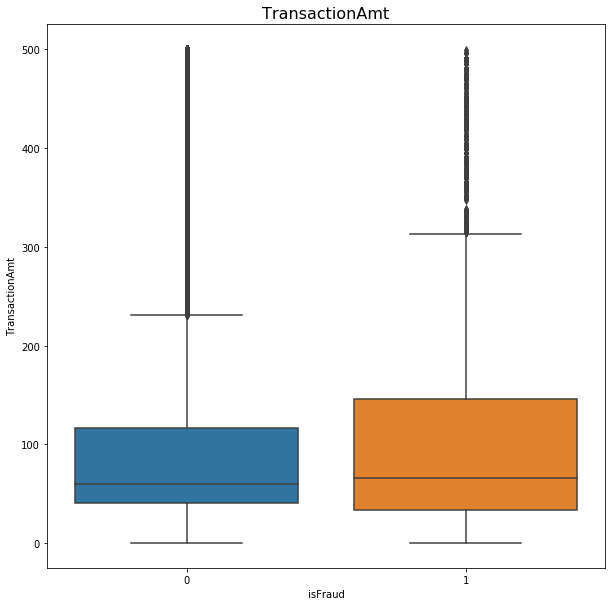

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
plot = sns.boxplot(x="isFraud", y="TransactionAmt", data=train.query("TransactionAmt < 500"), ax=ax).set_title('TransactionAmt', fontsize=16)
plt.show()

In [20]:
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
print("Transaction Amounts Quantiles:")
print(train['TransactionAmt'].quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))

Transaction Amounts Quantiles:
0.010       9.2440
0.025      14.5010
0.100      25.9500
0.250      43.3210
0.500      68.7690
0.750     125.0000
0.900     275.2930
0.975     648.3345
0.990    1104.0000
Name: TransactionAmt, dtype: float64


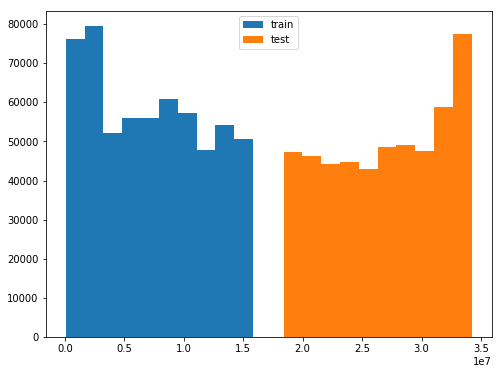

In [21]:
plt.figure(figsize=(8,6))
plt.hist(train['TransactionDT'], label='train');
plt.hist(test['TransactionDT'], label='test');
plt.legend();

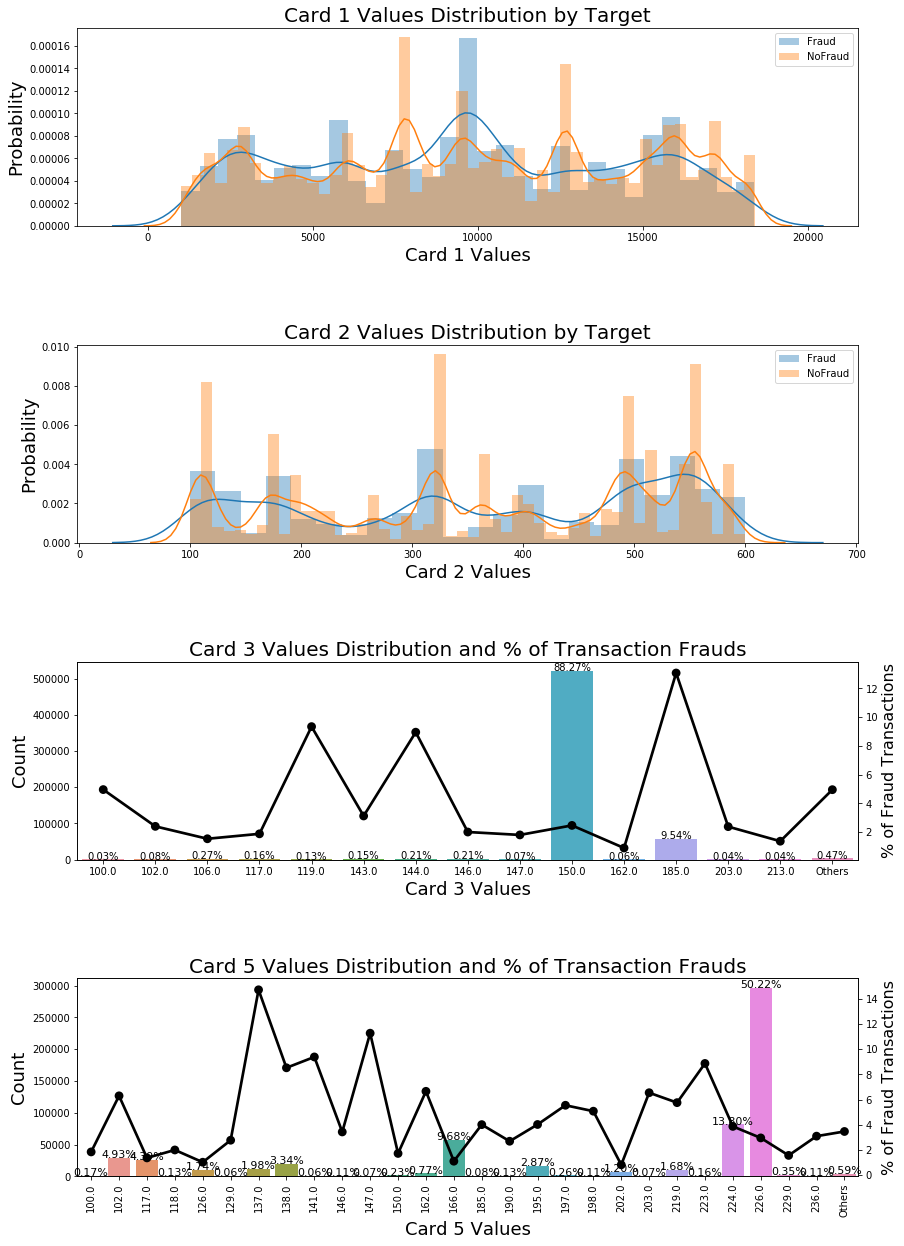

In [22]:
train.loc[train.card3.isin(train.card3.value_counts()[train.card3.value_counts() < 200].index), 'card3'] = "Others"
train.loc[train.card5.isin(train.card5.value_counts()[train.card5.value_counts() < 300].index), 'card5'] = "Others"


tmp = pd.crosstab(train['card3'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

tmp2 = pd.crosstab(train['card5'], train['isFraud'], normalize='index') * 100
tmp2 = tmp2.reset_index()
tmp2.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,22))

plt.subplot(411)
g = sns.distplot(train[train['isFraud'] == 1]['card1'], label='Fraud')
g = sns.distplot(train[train['isFraud'] == 0]['card1'], label='NoFraud')
g.legend()
g.set_title("Card 1 Values Distribution by Target", fontsize=20)
g.set_xlabel("Card 1 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)

plt.subplot(412)
g1 = sns.distplot(train[train['isFraud'] == 1]['card2'].dropna(), label='Fraud')
g1 = sns.distplot(train[train['isFraud'] == 0]['card2'].dropna(), label='NoFraud')
g1.legend()
g1.set_title("Card 2 Values Distribution by Target", fontsize=20)
g1.set_xlabel("Card 2 Values", fontsize=18)
g1.set_ylabel("Probability", fontsize=18)

plt.subplot(413)
g2 = sns.countplot(x='card3', data=train, order=list(tmp.card3.values))
g22 = g2.twinx()
gg2 = sns.pointplot(x='card3', y='Fraud', data=tmp, 
                    color='black', order=list(tmp.card3.values))
gg2.set_ylabel("% of Fraud Transactions", fontsize=16)
g2.set_title("Card 3 Values Distribution and % of Transaction Frauds", fontsize=20)
g2.set_xlabel("Card 3 Values", fontsize=18)
g2.set_ylabel("Count", fontsize=18)
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
            height + 25,
            '{:1.2f}%'.format(height/len(train)*100),
            ha="center") 

plt.subplot(414)
g3 = sns.countplot(x='card5', data=train, order=list(tmp2.card5.values))
g3t = g3.twinx()
g3t = sns.pointplot(x='card5', y='Fraud', data=tmp2, 
                    color='black', order=list(tmp2.card5.values))
g3t.set_ylabel("% of Fraud Transactions", fontsize=16)
g3.set_title("Card 5 Values Distribution and % of Transaction Frauds", fontsize=20)
g3.set_xticklabels(g3.get_xticklabels(),rotation=90)
g3.set_xlabel("Card 5 Values", fontsize=18)
g3.set_ylabel("Count", fontsize=18)
for p in g3.patches:
    height = p.get_height()
    g3.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(train)*100),
            ha="center",fontsize=11) 
    
plt.subplots_adjust(hspace = 0.6, top = 0.85)


plt.show()

## Feature Engineering

In [0]:
base_columns = list(train)

In [0]:
len(base_columns)

434

In [0]:
# train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand=True)
# test[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = test['P_emaildomain'].str.split('.', expand=True)
# train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = train['R_emaildomain'].str.split('.', expand=True)
# test[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = test['R_emaildomain'].str.split('.', expand=True)


emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', \
          'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', \
          'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', \
          'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', \
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', \
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', \
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', \
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', \
          'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', \
          'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', \
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', \
          'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', \
          'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', \
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', \
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', \
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']
for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [0]:
# Measure how the transaction amount compares to mean/min/max grouped by card1/card4
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')



train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')


test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')


In [0]:
i_cols = ['card1','card2','card3','card5', 'card6',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8','D9',
          'addr1','addr2',
          'dist1','dist2',
          'P_emaildomain', 'R_emaildomain'
         ]

for col in i_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()   
    train[col+'_fq_enc'] = train[col].map(fq_encode)
    test[col+'_fq_enc']  = test[col].map(fq_encode)

In [0]:
import datetime

# train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
# test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)

# train['Transaction_hour_of_day'] = np.floor(train['TransactionDT'] / 3600) % 24
# test['Transaction_hour_of_day'] = np.floor(test['TransactionDT'] / 3600) % 24

train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

train['TransactionAmt_Log'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt_Log'] = np.log1p(test['TransactionAmt'])


START_DATE = '2017-11-30'
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')

train['TransactionDT'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
test['TransactionDT'] = test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

train['year'] = train['TransactionDT'].dt.year
test['year'] = test['TransactionDT'].dt.year

train['month'] = train['TransactionDT'].dt.month
test['month'] = test['TransactionDT'].dt.month

train['dow'] = train['TransactionDT'].dt.dayofweek
test['dow'] = test['TransactionDT'].dt.dayofweek

train['hour'] = train['TransactionDT'].dt.hour
test['hour'] = test['TransactionDT'].dt.hour

train['day'] = train['TransactionDT'].dt.day
test['day'] = test['TransactionDT'].dt.day

In [0]:
########################### TransactionDT
import datetime

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
dates_range = pd.date_range(start='2017-10-01', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
remove_features = []

# Let's add temporary "time variables" for aggregations
# and add normal "time variables"
for df in [train, test]:
    
    # Temporary variables for aggregation
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = ((df['DT'].dt.year-2017)*12 + df['DT'].dt.month).astype(np.int8)
    df['DT_W'] = ((df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear).astype(np.int8)
    df['DT_D'] = ((df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear).astype(np.int16)
    
    df['DT_hour'] = (df['DT'].dt.hour).astype(np.int8)
    df['DT_day_week'] = (df['DT'].dt.dayofweek).astype(np.int8)
    df['DT_day_month'] = (df['DT'].dt.day).astype(np.int8)
        
    # Possible solo feature
    df['is_december'] = df['DT'].dt.month
    df['is_december'] = (df['is_december']==12).astype(np.int8)

    # Holidays
    df['is_holiday'] = (df['DT'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)

# Remove temporary features from final list
remove_features += ['DT','DT_M','DT_W','DT_D','DT_hour','DT_day_week','DT_day_month']
    
# Total transactions per timeblock
for col in ['DT_M','DT_W','DT_D']:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
            
    train[col+'_total'] = train[col].map(fq_encode)
    test[col+'_total']  = test[col].map(fq_encode)
    
    # We can't use it as solo feature
    remove_features.append(col+'_total')

In [0]:
a = np.zeros(train.shape[0])
train["lastest_browser"] = a
a = np.zeros(test.shape[0])
test["lastest_browser"] = a
def browser(df):
    df.loc[df["id_31"]=="samsung browser 7.0",'lastest_browser']=1
    df.loc[df["id_31"]=="opera 53.0",'lastest_browser']=1
    df.loc[df["id_31"]=="mobile safari 10.0",'lastest_browser']=1
    df.loc[df["id_31"]=="google search application 49.0",'lastest_browser']=1
    df.loc[df["id_31"]=="firefox 60.0",'lastest_browser']=1
    df.loc[df["id_31"]=="edge 17.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 69.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 67.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for ios",'lastest_browser']=1
    return df
train=browser(train)
test=browser(test)

In [0]:
def id_split(dataframe):
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

    dataframe['id_34'] = dataframe['id_34'].str.split(':', expand=True)[1]
    dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)[1]

    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    dataframe['had_id'] = 1
    gc.collect()
    
    return dataframe
  
train = id_split(train)
test = id_split(test)

In [0]:
train['P_isproton']=(train['P_emaildomain']=='protonmail.com')
train['R_isproton']=(train['R_emaildomain']=='protonmail.com')
test['P_isproton']=(test['P_emaildomain']=='protonmail.com')
test['R_isproton']=(test['R_emaildomain']=='protonmail.com')

In [0]:
train['nulls1'] = train.isna().sum(axis=1)
test['nulls1'] = test.isna().sum(axis=1)

In [0]:
for feature in ['id_36']:
    train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
    test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
        
for feature in ['id_01', 'id_31', 'id_35', 'id_36']:
    train[feature + '_count_dist'] = train[feature].map(train[feature].value_counts(dropna=False))
    test[feature + '_count_dist'] = test[feature].map(test[feature].value_counts(dropna=False))

In [0]:
########################### D9 and TransactionDT
# Let's add temporary "time variables" for aggregations
# and add normal "time variables"

# Also, seems that D9 column is an hour
# and it is the same as df['DT'].dt.hour

import datetime

START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

for df in [train, test]:
    # Temporary
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = (df['DT'].dt.year-2017)*12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day
    
    # D9 column
    df['D9'] = np.where(df['D9'].isna(),0,1)

In [0]:
########################### Reset values for "noise" card1
    
for col in ['card1']:
  valid_card = pd.concat([train[[col]], test[[col]]])
  valid_card = valid_card[col].value_counts()
  valid_card_std = valid_card.values.std()

  invalid_cards = valid_card[valid_card<=2]
  print('Rare cards',len(invalid_cards))

  valid_card = valid_card[valid_card>2]
  valid_card = list(valid_card.index)

  print('No intersection in Train', len(train[~train[col].isin(test[col])]))
  print('Intersection in Train', len(train[train[col].isin(test[col])]))

  train[col] = np.where(train[col].isin(test[col]), train[col], np.nan)
  test[col]  = np.where(test[col].isin(train[col]), test[col], np.nan)

  train[col] = np.where(train[col].isin(valid_card), train[col], np.nan)
  test[col]  = np.where(test[col].isin(valid_card), test[col], np.nan)
  print('#'*20)

for col in ['card2','card3','card4','card5','card6']: 
  print('No intersection in Train', col, len(train[~train[col].isin(test[col])]))
  print('Intersection in Train', col, len(train[train[col].isin(test[col])]))

  train[col] = np.where(train[col].isin(test[col]), train[col], np.nan)
  test[col]  = np.where(test[col].isin(train[col]), test[col], np.nan)
  print('#'*20)

Rare cards 5993
No intersection in Train 10396
Intersection in Train 580144
####################
No intersection in Train card2 5012
Intersection in Train card2 585528
####################
No intersection in Train card3 47
Intersection in Train card3 590493
####################
No intersection in Train card4 0
Intersection in Train card4 590540
####################
No intersection in Train card5 7279
Intersection in Train card5 583261
####################
No intersection in Train card6 30
Intersection in Train card6 590510
####################


In [0]:
########################### M columns (except M4)
# All these columns are binary encoded 1/0
# We can have some features from it
i_cols = ['M1','M2','M3','M5','M6','M7','M8','M9']

for df in [train, test]:
    df['M_sum'] = df[i_cols].sum(axis=1).astype(np.int8)
    df['M_na'] = df[i_cols].isna().sum(axis=1).astype(np.int8)

In [0]:
########################### ProductCD and M4 Target mean
for col in ['ProductCD','M4']:
    temp_dict1 = train.groupby([col])['isFraud'].agg(['mean']).reset_index().rename(
                                                        columns={'mean': col+'_target_mean'})
    
    temp_dict2 = train.groupby([col])['isFraud'].agg(['std']).reset_index().rename(
                                                        columns={'std': col+'_target_std'})
    temp_dict1.index = temp_dict1[col].values
    temp_dict2.index = temp_dict2[col].values
    temp_dict1 = temp_dict1[col+'_target_mean'].to_dict()
    temp_dict2 = temp_dict2[col+'_target_std'].to_dict()

    train[col+'_target_mean'] = train[col].map(temp_dict1)
    test[col+'_target_mean']  = test[col].map(temp_dict1)
    train[col+'_target_std'] = train[col].map(temp_dict2)
    test[col+'_target_std']  = test[col].map(temp_dict2)

In [0]:
def frequency_encoding(train_df, test_df, columns, self_encoding=False):
    for col in columns:
        temp_df = pd.concat([train_df[[col]], test_df[[col]]])
        fq_encode = temp_df[col].value_counts(dropna=False).to_dict()
        if self_encoding:
            train_df[col] = train_df[col].map(fq_encode)
            test_df[col]  = test_df[col].map(fq_encode)            
        else:
            train_df[col+'_fq_enc'] = train_df[col].map(fq_encode)
            test_df[col+'_fq_enc']  = test_df[col].map(fq_encode)
    return train_df, test_df

In [0]:
########################### Client Virtual ID
# Let's add some kind of client uID based on cardID and addr columns
# The value will be very specific for each client so we need to remove it
# from final features. But we can use it for aggregations.
train['uid'] = train['card1'].astype(str)+'_'+train['card2'].astype(str)
test['uid'] = test['card1'].astype(str)+'_'+test['card2'].astype(str)

train['uid2'] = train['uid'].astype(str)+'_'+train['card3'].astype(str)+'_'+train['card5'].astype(str)
test['uid2'] = test['uid'].astype(str)+'_'+test['card3'].astype(str)+'_'+test['card5'].astype(str)

train['uid3'] = train['uid2'].astype(str)+'_'+train['addr1'].astype(str)+'_'+train['addr2'].astype(str)
test['uid3'] = test['uid2'].astype(str)+'_'+test['addr1'].astype(str)+'_'+test['addr2'].astype(str)

train['uid4'] = train['uid3'].astype(str)+'_'+train['P_emaildomain'].astype(str)
test['uid4'] = test['uid3'].astype(str)+'_'+test['P_emaildomain'].astype(str)

train['uid5'] = train['uid3'].astype(str)+'_'+train['R_emaildomain'].astype(str)
test['uid5'] = test['uid3'].astype(str)+'_'+test['R_emaildomain'].astype(str)

# Add values remove list
new_columns = ['uid','uid2','uid3','uid4','uid5']
remove_features += new_columns

print('#'*10)
print('Most common uIds:')
for col in new_columns:
    print('#'*10, col)
    print(train[col].value_counts()[:10])

# Do Global frequency encoding 
i_cols = ['card1','card2','card3','card5'] + new_columns
train, test = frequency_encoding(train, test, i_cols, self_encoding=False)

##########
Most common uIds:
########## uid
7919.0_194.0     14891
9500.0_321.0     14112
15885.0_545.0    10332
17188.0_321.0    10312
15066.0_170.0     7918
12695.0_490.0     7079
6019.0_583.0      6766
12544.0_321.0     6760
2803.0_100.0      6126
7585.0_553.0      5325
Name: uid, dtype: int64
########## uid2
9500.0_321.0_150.0_226.0     14112
15885.0_545.0_185.0_138.0    10332
17188.0_321.0_150.0_226.0    10312
7919.0_194.0_150.0_166.0      8844
15066.0_170.0_150.0_102.0     7918
12695.0_490.0_150.0_226.0     7079
6019.0_583.0_150.0_226.0      6766
12544.0_321.0_150.0_226.0     6760
2803.0_100.0_150.0_226.0      6126
7919.0_194.0_150.0_nan        6047
Name: uid2, dtype: int64
########## uid3
15885.0_545.0_185.0_138.0_nan_nan       9900
17188.0_321.0_150.0_226.0_299.0_87.0    5862
12695.0_490.0_150.0_226.0_325.0_87.0    5766
9500.0_321.0_150.0_226.0_204.0_87.0     4647
3154.0_408.0_185.0_224.0_nan_nan        4398
12839.0_321.0_150.0_226.0_264.0_87.0    3538
16132.0_111.0_150.0_226.0

In [0]:
########################### TransactionAmt

# Let's add some kind of client uID based on cardID ad addr columns
# The value will be very specific for each client so we need to remove it
# from final feature. But we can use it for aggregations.
train['uid'] = train['card1'].astype(str)+'_'+train['card2'].astype(str)+'_'+train['card3'].astype(str)+'_'+train['card4'].astype(str)
test['uid'] = test['card1'].astype(str)+'_'+test['card2'].astype(str)+'_'+test['card3'].astype(str)+'_'+test['card4'].astype(str)

train['uid2'] = train['uid'].astype(str)+'_'+train['addr1'].astype(str)+'_'+train['addr2'].astype(str)
test['uid2'] = test['uid'].astype(str)+'_'+test['addr1'].astype(str)+'_'+test['addr2'].astype(str)

train['uid3'] = train['uid2'].astype(str)+'_'+train['addr1'].astype(str)+'_'+train['addr2'].astype(str)
test['uid3'] = test['uid2'].astype(str)+'_'+test['addr1'].astype(str)+'_'+test['addr2'].astype(str)

# Check if Transaction Amount is common or not (we can use freq encoding here)
# In our dialog with model we are telling to trust or not to these values  
# valid_card = train['TransactionAmt'].value_counts()
# valid_card = valid_card[valid_card>10]
# valid_card = list(valid_card.index)
    
train['TransactionAmt_check'] = np.where(train['TransactionAmt'].isin(test['TransactionAmt']), 1, 0)
test['TransactionAmt_check']  = np.where(test['TransactionAmt'].isin(train['TransactionAmt']), 1, 0)

# For our model current TransactionAmt is a noise (even when features importances are telling contrariwise)
# There are many unique values and model doesn't generalize well
# Lets do some aggregations
i_cols = ['card1','card2','card3','card5','uid','uid2','uid3']

for col in i_cols:
    for agg_type in ['mean', 'std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
        temp = temp.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})
        
        temp.index = list(temp[col])
        temp = temp[new_col_name].to_dict()   
    
        train[new_col_name] = train[col].map(temp)
        test[new_col_name]  = test[col].map(temp)

# Small "hack" to transform distribution 
# (doesn't affect auc much, but I like it more)
# please see how distribution transformation can boost your score 
# (not our case but related)
# https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html
# train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
# test['TransactionAmt'] = np.log1p(test['TransactionAmt'])

In [0]:
########################### card3/card5 most common hour 
# card3 or card5 is a bank country?
# can we find:
# - the most popular Transaction Hour
# - the most popular Week Day
# and then find distance from it

# Prepare bank type feature
for df in [train, test]:
    df['bank_type'] = df['card3'].astype(str) +'_'+ df['card5'].astype(str)
remove_features.append('bank_type') 

encoding_mean = {
    1: ['DT_D','DT_hour','_hour_dist','DT_hour_mean'],
    2: ['DT_W','DT_day_week','_week_day_dist','DT_day_week_mean'],
    3: ['DT_M','DT_day_month','_month_day_dist','DT_day_month_mean'],
    }

encoding_best = {
    1: ['DT_D','DT_hour','_hour_dist_best','DT_hour_best'],
    2: ['DT_W','DT_day_week','_week_day_dist_best','DT_day_week_best'],
    3: ['DT_M','DT_day_month','_month_day_dist_best','DT_day_month_best'],   
    }

# Some ugly code here (even worse than in other parts)
for col in ['card3','card5','bank_type']:
    for df in [train, test]:
        for encode in encoding_mean:
            encode = encoding_mean[encode].copy()
            new_col = col + '_' + encode[0] + encode[2]
            df[new_col] = df[col].astype(str) +'_'+ df[encode[0]].astype(str)

            temp_dict = df.groupby([new_col])[encode[1]].agg(['mean']).reset_index().rename(
                                                                    columns={'mean': encode[3]})
            temp_dict.index = temp_dict[new_col].values
            temp_dict = temp_dict[encode[3]].to_dict()
            df[new_col] = df[encode[1]] - df[new_col].map(temp_dict)

        for encode in encoding_best:
            encode = encoding_best[encode].copy()
            new_col = col + '_' + encode[0] + encode[2]
            df[new_col] = df[col].astype(str) +'_'+ df[encode[0]].astype(str)
            temp_dict = df.groupby([col,encode[0],encode[1]])[encode[1]].agg(['count']).reset_index().rename(
                                                                    columns={'count': encode[3]})

            temp_dict.sort_values(by=[col,encode[0],encode[3]], inplace=True)
            temp_dict = temp_dict.drop_duplicates(subset=[col,encode[0]], keep='last')
            temp_dict[new_col] = temp_dict[col].astype(str) +'_'+ temp_dict[encode[0]].astype(str)
            temp_dict.index = temp_dict[new_col].values
            temp_dict = temp_dict[encode[1]].to_dict()
            df[new_col] = df[encode[1]] - df[new_col].map(temp_dict)

In [0]:
def timeblock_frequency_encoding(train_df, test_df, periods, columns, 
                                 with_proportions=True, only_proportions=False):
    for period in periods:
        for col in columns:
            new_col = col +'_'+ period
            train_df[new_col] = train_df[col].astype(str)+'_'+train_df[period].astype(str)
            test_df[new_col]  = test_df[col].astype(str)+'_'+test_df[period].astype(str)

            temp_df = pd.concat([train_df[[new_col]], test_df[[new_col]]])
            fq_encode = temp_df[new_col].value_counts().to_dict()

            train_df[new_col] = train_df[new_col].map(fq_encode)
            test_df[new_col]  = test_df[new_col].map(fq_encode)
            
            if only_proportions:
                train_df[new_col] = train_df[new_col]/train_df[period+'_total']
                test_df[new_col]  = test_df[new_col]/test_df[period+'_total']

            if with_proportions:
                train_df[new_col+'_proportions'] = train_df[new_col]/train_df[period+'_total']
                test_df[new_col+'_proportions']  = test_df[new_col]/test_df[period+'_total']

    return train_df, test_df

In [0]:
########################### bank_type
# Tracking nomal activity
# by doing timeblock frequency encoding
i_cols = ['bank_type'] #['uid','uid2','uid3','uid4','uid5','bank_type']
periods = ['DT_M','DT_W','DT_D']

# We have few options to encode it here:
# - Just count transactions
# (but some timblocks have more transactions than others)
# - Devide to total transactions per timeblock (proportions)
# - Use both
# - Use only proportions
train, test = timeblock_frequency_encoding(train, test, periods, i_cols, 
                                 with_proportions=False, only_proportions=True)

In [0]:
def uid_aggregation(train_df, test_df, main_columns, uids, aggregations):
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = col+'_'+main_column+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name]  = test_df[col].map(temp_df)
    return train_df, test_df

def uid_aggregation_and_normalization(train_df, test_df, main_columns, uids, aggregations):
    for main_column in main_columns:  
        for col in uids:
            
            new_norm_col_name = col+'_'+main_column+'_std_norm'
            norm_cols = []
            
            for agg_type in aggregations:
                new_col_name = col+'_'+main_column+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name]  = test_df[col].map(temp_df)
                norm_cols.append(new_col_name)
            
            train_df[new_norm_col_name] = (train_df[main_column]-train_df[norm_cols[0]])/train_df[norm_cols[1]]
            test_df[new_norm_col_name]  = (test_df[main_column]-test_df[norm_cols[0]])/test_df[norm_cols[1]]          
            
            del train_df[norm_cols[0]], train_df[norm_cols[1]]
            del test_df[norm_cols[0]], test_df[norm_cols[1]]
                                              
    return train_df, test_df

In [0]:
def values_normalization(dt_df, periods, columns):
    for period in periods:
        for col in columns:
            new_col = col +'_'+ period
            dt_df[col] = dt_df[col].astype(float)  

            temp_min = dt_df.groupby([period])[col].agg(['min']).reset_index()
            temp_min.index = temp_min[period].values
            temp_min = temp_min['min'].to_dict()

            temp_max = dt_df.groupby([period])[col].agg(['max']).reset_index()
            temp_max.index = temp_max[period].values
            temp_max = temp_max['max'].to_dict()

            temp_mean = dt_df.groupby([period])[col].agg(['mean']).reset_index()
            temp_mean.index = temp_mean[period].values
            temp_mean = temp_mean['mean'].to_dict()

            temp_std = dt_df.groupby([period])[col].agg(['std']).reset_index()
            temp_std.index = temp_std[period].values
            temp_std = temp_std['std'].to_dict()

            dt_df['temp_min'] = dt_df[period].map(temp_min)
            dt_df['temp_max'] = dt_df[period].map(temp_max)
            dt_df['temp_mean'] = dt_df[period].map(temp_mean)
            dt_df['temp_std'] = dt_df[period].map(temp_std)

            dt_df[new_col+'_min_max'] = (dt_df[col]-dt_df['temp_min'])/(dt_df['temp_max']-dt_df['temp_min'])
            dt_df[new_col+'_std_score'] = (dt_df[col]-dt_df['temp_mean'])/(dt_df['temp_std'])
            del dt_df['temp_min'],dt_df['temp_max'],dt_df['temp_mean'],dt_df['temp_std']
    return dt_df

In [0]:
########################### D Columns
# From columns description we know that
# D1-D15: timedelta, such as days between previous transaction, etc.
# 1. I can't imagine normal negative timedelta values (Let's clip Values)
# 2. Normalize (Min-Max, Standard score) All D columns, except D1,D2,D9
# 3. Do some aggregations based on uIDs
# 4. Freaquency encoding
# 5. D1,D2 are clipped by max train values (let's scale it)
i_cols = ['D'+str(i) for i in range(1,16)]
uids = ['uid','uid2','uid3','uid4','uid5','bank_type']
aggregations = ['mean','std']

####### uIDs aggregations
train, test = uid_aggregation(train, test, i_cols, uids, aggregations)

####### Cleaning Neagtive values and columns transformations
for df in [train, test]:

    for col in i_cols:
        df[col] = df[col].clip(0) 
    
    # Lets transform D8 and D9 column
    # As we almost sure it has connection with hours
    df['D9_not_na'] = np.where(df['D9'].isna(),0,1)
    df['D8_not_same_day'] = np.where(df['D8']>=1,1,0)
    df['D8_D9_decimal_dist'] = df['D8'].fillna(0)-df['D8'].fillna(0).astype(int)
    df['D8_D9_decimal_dist'] = ((df['D8_D9_decimal_dist']-df['D9'])**2)**0.5
    df['D8'] = df['D8'].fillna(-1).astype(int)

####### Values Normalization
i_cols.remove('D1')
i_cols.remove('D2')
i_cols.remove('D9')
periods = ['DT_D','DT_W','DT_M']
for df in [train, test]:
    df = values_normalization(df, periods, i_cols)
    
for col in ['D1','D2']:
    for df in [train, test]:
        df[col+'_scaled'] = df[col]/train[col].max()

####### Global Self frequency encoding
# self_encoding=True because
# we don't need original values anymore
i_cols = ['D'+str(i) for i in range(1,16)]
train, test = frequency_encoding(train, test, i_cols, self_encoding=True)

In [0]:
########################### TransactionAmt
# For our model current TransactionAmt is a noise
# https://www.kaggle.com/kyakovlev/ieee-check-noise
# (even if features importances are telling contrariwise)
# There are many unique values and model doesn't generalize well
# Lets do some aggregations
i_cols = ['TransactionAmt']
uids = ['card1','card2','card3','card5','uid','uid2','uid3','uid4','uid5','bank_type']
aggregations = ['mean','std']

# uIDs aggregations
train, test = uid_aggregation(train, test, i_cols, uids, aggregations)
 
# TransactionAmt Normalization
periods = ['DT_D','DT_W','DT_M']
for df in [train, test]:
    df = values_normalization(df, periods, i_cols)

# Product type
train['product_type'] = train['ProductCD'].astype(str)+'_'+train['TransactionAmt'].astype(str)
test['product_type'] = test['ProductCD'].astype(str)+'_'+test['TransactionAmt'].astype(str)

i_cols = ['product_type']
periods = ['DT_D','DT_W','DT_M']
train, test = timeblock_frequency_encoding(train, test, periods, i_cols, 
                                                 with_proportions=False, only_proportions=True)
train, test = frequency_encoding(train, test, i_cols, self_encoding=True)

In [0]:
########################### C Columns
i_cols = ['C'+str(i) for i in range(1,15)]

####### Global Self frequency encoding
# self_encoding=False because 
# I want to keep original values
train, test = frequency_encoding(train, test, i_cols, self_encoding=False)

####### Clip max values
for df in [train, test]:
    for col in i_cols:
        max_value = train[train['DT_M']==train['DT_M'].max()][col].max()
        df[col] = df[col].clip(None,max_value) 

In [0]:
########################### 'P_emaildomain' - 'R_emaildomain'
p = 'P_emaildomain'
r = 'R_emaildomain'
uknown = 'email_not_provided'

for df in [train, test]:
    df[p] = df[p].fillna(uknown)
    df[r] = df[r].fillna(uknown)
    
    # Check if P_emaildomain matches R_emaildomain
    df['email_check'] = np.where((df[p]==df[r])&(df[p]!=uknown),1,0)

    df[p+'_prefix'] = df[p].apply(lambda x: x.split('.')[0])
    df[r+'_prefix'] = df[r].apply(lambda x: x.split('.')[0])

## Local test doesn't show any boost here, 
## but I think it's a good option for model stability 

## Also, we will do frequency encoding later

In [0]:
########################### Device info
for df in [train, test]:
    ########################### Device info
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    df['DeviceInfo_device'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['DeviceInfo_version'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    ########################### Device info 2
    df['id_30'] = df['id_30'].fillna('unknown_device').str.lower()
    df['id_30_device'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['id_30_version'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    ########################### Browser
    df['id_31'] = df['id_31'].fillna('unknown_device').str.lower()
    df['id_31_device'] = df['id_31'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))

In [0]:
########################### Freq encoding
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8',
          'addr1','addr2',
          'dist1','dist2',
          'P_emaildomain', 'R_emaildomain',
          'DeviceInfo','DeviceInfo_device','DeviceInfo_version',
          'id_30','id_30_device','id_30_version',
          'id_31_device',
          'id_33',
          'uid','uid2','uid3',
         ]

for col in i_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()   
    train[col+'_fq_enc'] = train[col].map(fq_encode)
    test[col+'_fq_enc']  = test[col].map(fq_encode)


for col in ['DT_M','DT_W','DT_D']:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
            
    train[col+'_total'] = train[col].map(fq_encode)
    test[col+'_total']  = test[col].map(fq_encode)
        

periods = ['DT_M','DT_W','DT_D']
i_cols = ['uid']
for period in periods:
    for col in i_cols:
        new_column = col + '_' + period
            
        temp_df = pd.concat([train[[col,period]], test[[col,period]]])
        temp_df[new_column] = temp_df[col].astype(str) + '_' + (temp_df[period]).astype(str)
        fq_encode = temp_df[new_column].value_counts().to_dict()
            
        train[new_column] = (train[col].astype(str) + '_' + train[period].astype(str)).map(fq_encode)
        test[new_column]  = (test[col].astype(str) + '_' + test[period].astype(str)).map(fq_encode)
        
        train[new_column] /= train[period+'_total']
        test[new_column]  /= test[period+'_total']

In [0]:
########################### Encode Str columns
# For all such columns (probably not)
# we already did frequency encoding (numeric feature)
# so we will use astype('category') here
for col in list(train):
    if train[col].dtype=='O':
        print(col)
        train[col] = train[col].fillna('unseen_before_label')
        test[col]  = test[col].fillna('unseen_before_label')
        
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        
        le = LabelEncoder()
#         le.fit(list(train[col])+list(test[col]))
#         train[col] = le.transform(train[col])
#         test[col]  = le.transform(test[col])
        
#         train[col] = train[col].astype('category')
#         test[col] = test[col].astype('category')
        
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))   

ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_12
id_15
id_16
id_23
id_27
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo
P_emaildomain_bin
P_emaildomain_suffix
R_emaildomain_bin
R_emaildomain_suffix
device_name
device_version
OS_id_30
version_id_30
browser_id_31
version_id_31
screen_width
screen_height
uid
uid2
uid3
uid4
uid5
bank_type
P_emaildomain_prefix
R_emaildomain_prefix
DeviceInfo_device
DeviceInfo_version
id_30_device
id_30_version
id_31_device


In [0]:
some_cols_to_drop = [
#     'TransactionID','TransactionDT', # These columns are pure noise right now
#     'isFraud',                          # Not target in features))
    'uid','uid2','uid3',             # Our new client uID -> very noisy data
#     'bank_type',                     # Victims bank could differ by time
    'DT','DT_M','DT_W','DT_D',       # Temporary Variables
    'DT_hour','DT_day_week','DT_day',
    'DT_D_total','DT_W_total','DT_M_total',
    'id_30','id_31','id_33',
]

In [0]:
########################### Features elimination 
from scipy.stats import ks_2samp
features_check = []
columns_to_check = set(list(train)).difference(base_columns+cols_to_drop)
for i in columns_to_check:
    features_check.append(ks_2samp(test[i], train[i])[1])

features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
features_discard = list(features_check[features_check==0].index)
print(features_discard)

NameError: ignored

In [0]:
from sklearn import preprocessing

for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1',
                'card1__dist1', 'card2__card5', 'addr1__card4', 'addr1__card2']:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

    le =preprocessing.LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))
    
for feature in ['id_34', 'id_36']:
    # Count encoded for both train and test
    train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
    test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
        
for feature in ['id_01', 'id_31', 'id_33', 'id_35', 'id_36']:
    # Count encoded separately for train and test
    train[feature + '_count_dist'] = train[feature].map(train[feature].value_counts(dropna=False))
    test[feature + '_count_dist'] = test[feature].map(test[feature].value_counts(dropna=False))
    
category_features=["ProductCD","P_emaildomain",
                   "R_emaildomain","M1","M2","M3","M4","M5","M6","M7","M8","M9","DeviceType","DeviceInfo","id_12",
                   "id_13","id_14","id_15","id_16","id_17","id_18","id_19","id_20","id_21","id_22","id_23","id_24",
                   "id_25","id_26","id_27","id_28","id_29","id_30","id_32","id_34", 'id_36'
                   "id_37","id_38"]
for c in category_features:
    train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
    test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))

In [0]:
# Drop columns with more than 90% null values
null_cols_train = [col for col in train.columns if train[col].isnull().sum() / len(train) > 0.9]
null_cols_test = [col for col in test.columns if test[col].isnull().sum() / len(test) > 0.9]

In [0]:
# Drop column with a single value dominating > 90%
dominant_cols_train = [col for col in train.columns \
                      if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
dominant_cols_test = [col for col in test.columns \
                      if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [0]:
# dominant_cols_train = []
# dominant_cols_test = []
cols_to_drop = list(set(null_cols_train + null_cols_test + dominant_cols_train + dominant_cols_test + remove_features))
cols_to_drop.remove('isFraud')
len(cols_to_drop)

120

In [0]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [0]:
rm_cols = cols_to_drop + features_discard
# rm_cols.remove('bank_type')
# rm_cols.remove('isFraud')
# rm_cols.remove('TransactionID')
# rm_cols.remove('TransactionDT')
for col in rm_cols:
  if col in list(train):
    train = train.drop(col, axis=1)
    
  if col in list(test):
    test = test.drop(col, axis=1)
# train = train.drop(cols_to_drop+features_discard, axis=1)
# test = test.drop(cols_to_drop+features_discard, axis=1)

# train = train.fillna(-999)
# test = test.fillna(-999)

In [0]:
########################### Fill numerical columns
numerical_columns = list(test.select_dtypes(exclude=['object', 'datetime']).columns)

for col in numerical_columns:
  train[col] = train[col].fillna(train[col].median())
  test[col] = test[col].fillna(train[col].median())
  
print("filling numerical columns null values done")

filling numerical columns null values done


In [0]:
########################### Fill categorical columns
categorical_columns = list(filter(lambda x: x not in numerical_columns, list(test.columns)))

for col in categorical_columns:
  train[col] = train[col].fillna(train[col].mode())
  test[col] = test[col].fillna(train[col].mode())
print("filling categorical columns null values done")

filling categorical columns null values done


In [0]:
for col in list(train):
    if train[col].dtype=='O':
        print(col)
        train[col] = train[col].fillna('unseen_before_label')
        test[col]  = test[col].fillna('unseen_before_label')

c_cols = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14']
c_cols_lst = [col+'_valid' for col in c_cols]

cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18',\
            'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',\
            'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',\
            'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',\
            'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', \
            'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9', \
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', \
            'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3',
            'OS_id_30', 'version_id_30', 'browser_id_31', 'version_id_31', \
            'screen_width', 'screen_height', 'device_name', 'P_emaildomain_bin', \
            'P_emaildomain_suffix', 'R_emaildomain_bin', 'R_emaildomain_suffix', \
            'uid', 'uid2', 'uid3', 'TransactionAmt_check', 'M_type', 'C_sum', 'C_null', \
            'bank_type', 'address_match', 'M4_target_mean', 'ProductCD_target_mean'] \
          + c_cols_lst
for col in cat_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))   

In [0]:
# X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID', \
#                                             'uid', 'uid2', 'bank_type'], axis=1)
X = train.sort_values('TransactionDT').drop(['isFraud','TransactionDT','TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
# X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID', \
#                                                 'uid', 'uid2', 'bank_type'], axis=1)
X_test = test.sort_values('TransactionDT').drop(['TransactionDT','TransactionID'], axis=1)
del train
test = test[["TransactionDT", 'TransactionID']]

In [0]:
# by https://www.kaggle.com/dimartinot
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# Cleaning infinite values to NaN
X = clean_inf_nan(X)
X_test = clean_inf_nan(X_test)

In [0]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [0]:
rm_cols = ['DT','DT_M','DT_W','DT_D',       # Temporary Variables
    'DT_hour','DT_day_week','DT_day',
    'DT_D_total','DT_W_total','DT_M_total']

for col in rm_cols:
  if col in list(X):
    X = X.drop(col, axis=1)
  if col in list(X_test):
    X_test = X_test.drop(col, axis=1)

In [0]:
X_test = reduce_mem_usage(X_test)
X = reduce_mem_usage(X)

Memory usage of dataframe is 2949.56 MB
Memory usage after optimization is: 811.81 MB
Decreased by 72.5%
Memory usage of dataframe is 3437.67 MB
Memory usage after optimization is: 937.14 MB
Decreased by 72.7%


In [0]:
for col in X.columns:
  print(f'{col} {X[col].dtype}')

In [0]:
gc.collect()

35

In [0]:
n_fold = 5
# folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=5)

In [0]:
def lgb_classification(X, y, X_test, params, folds):
    columns = X.columns
    n_splits = folds.n_splits
    X_test = X_test[columns]

    # out-of-fold predictions on train data
    oof = np.zeros(len(X))

    # averaged predictions on train data
    prediction = np.zeros(len(X_test))

    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n+1} started at {time.ctime()}')
        X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        model = lgb.LGBMClassifier(**params, n_estimators=1000, n_jobs=-1)
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  eval_metric='auc',
                  verbose=500, early_stopping_rounds=100)
        y_pred_valid = model.predict_proba(X_valid)[:, 1]
        y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]
        
        oof[valid_index] = y_pred_valid.reshape(-1)
        scores.append(metrics.roc_auc_score(y_valid, y_pred_valid))
        prediction += y_pred.reshape(-1)

        fold_importance = pd.DataFrame()
        fold_importance["feature"] = columns
        fold_importance["importance"] = model.feature_importances_
        fold_importance["fold"] = fold_n + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
        
    return oof, prediction, scores, feature_importance

In [0]:
def xgb_classification(X, y, X_test, params, folds):
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))

    # averaged predictions on train data
    prediction = np.zeros(len(X_test))

    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    columns=X.columns
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        print('Use XGB')
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train),(X_valid, y_valid)],
                  eval_metric='auc',
                  verbose=500, early_stopping_rounds=200)
        y_pred_valid = model.predict_proba(X_valid)[:, 1]
        y_pred = model.predict_proba(X_test)[:, 1]

        scores.append(metrics.roc_auc_score(y_valid, y_pred_valid))
        prediction += y_pred.reshape(-1)

        fold_importance = pd.DataFrame()
        fold_importance["feature"] = columns
        fold_importance["importance"] = model.feature_importances_
        fold_importance["fold"] = fold_n + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
            
    
    return oof, prediction, scores, feature_importance

In [0]:
params = {'num_leaves': 256,
          'max_bin': 255,
#           'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.7,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.243,
          'colsample_bytree': 0.5,
#           'bagging_fraction': 0.42,
          'device': 'gpu'
#           'categorical_feature': cat_cols
         }
oof, prediction, scores, feature_importance = lgb_classification(X, y, X_test, params, folds)

Fold 1 started at Wed Sep  4 23:52:00 2019
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.999973	valid_1's auc: 0.920463
Early stopping, best iteration is:
[628]	training's auc: 0.999982	valid_1's auc: 0.92095
Fold 2 started at Thu Sep  5 00:08:09 2019
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.999998	valid_1's auc: 0.942803
Early stopping, best iteration is:
[627]	training's auc: 1	valid_1's auc: 0.94307
Fold 3 started at Thu Sep  5 00:24:42 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[375]	training's auc: 0.999938	valid_1's auc: 0.938184
Fold 4 started at Thu Sep  5 00:35:28 2019
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.999995	valid_1's auc: 0.954503
Early stopping, best iteration is:
[441]	training's auc: 0.999986	valid_1's auc: 0.954676
Fold 5 started at Thu Sep  5 00:47:53 2019
Training until va

CV mean score: 0.9384, std: 0.0110.


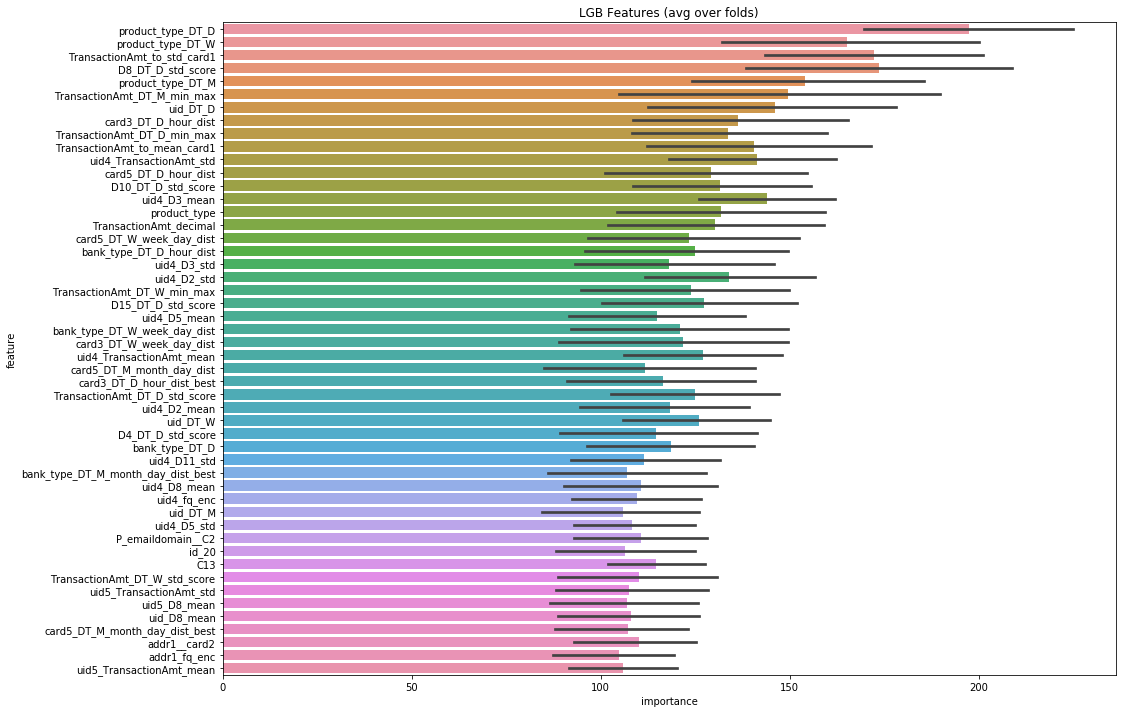

In [0]:
result_dict = {}

n_splits = 5

prediction /= n_splits
    
print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))

result_dict['oof'] = oof
result_dict['prediction'] = prediction
result_dict['scores'] = scores

feature_importance["importance"] /= n_splits
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

result_dict['feature_importance'] = feature_importance
result_dict['top_columns'] = cols

## Use XGB as well

In [0]:
xgb_params = {
    'n_estimators': 512,
#     'min_child_weight': 0.0345,
    'colsample_bytree': 0.85,
#     'bagging_fraction': 0.4181,
#     'min_data_in_leaf': 106,
    'n_jobs': -1,
    'max_depth': 9,
    'learning_rate': 0.05,
#     "bagging_seed": 11,
#     "verbosity": -1,
    'reg_alpha': 0.3,
    'reg_lambda': 0.243,
#     'missing': -999,
    'tree_method': 'gpu_hist'
    
}

In [0]:
oof_xgb, pred_xgb, scores_xgb, feature_xgb = xgb_classification(X, y, X_test, xgb_params, folds)

Use XGB
Fold 1 started at Wed Aug 28 17:30:33 2019
[0]	validation_0-auc:0.811297	validation_1-auc:0.797959
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[500]	validation_0-auc:0.995438	validation_1-auc:0.919329
[511]	validation_0-auc:0.995627	validation_1-auc:0.919276
Use XGB
Fold 2 started at Wed Aug 28 17:44:34 2019
[0]	validation_0-auc:0.807569	validation_1-auc:0.805676
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[500]	validation_0-auc:0.994666	validation_1-auc:0.938887
[511]	validation_0-auc:0.994945	validation_1-auc:0.939013
Use XGB
Fold 3 started at Wed Aug 28 17:58:15 2019
[0]	validation_0-auc:0.816679	validation_1-auc:0.794292
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn

CV mean score: 0.9316, std: 0.0099.


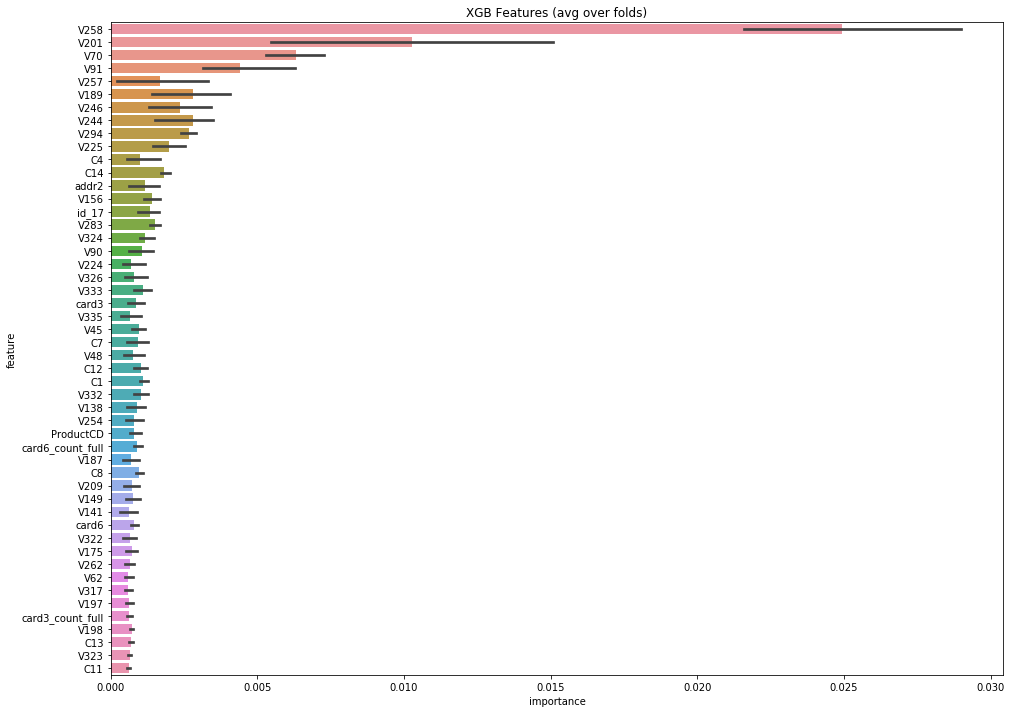

In [0]:
xgb_dict = {}

n_splits = 5

pred_xgb /= n_splits
    
print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores_xgb), np.std(scores_xgb)))

xgb_dict['oof'] = oof_xgb
xgb_dict['prediction'] = pred_xgb
xgb_dict['scores'] = scores_xgb

feature_xgb["importance"] /= n_splits
cols = feature_xgb[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_xgb.loc[feature_xgb.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('XGB Features (avg over folds)');

xgb_dict['feature_importance'] = feature_xgb
xgb_dict['top_columns'] = cols

In [0]:
test = test.sort_values('TransactionDT')
test['prediction'] = xgb_dict['prediction']

NameError: ignored

In [0]:
sample_sub['isFraud'] = pd.merge(sample_sub, test, on='TransactionID')['prediction']
sample_sub.to_csv('/content/drive/My Drive/Colab Notebooks/submission.csv', index=False)

In [0]:
# Final prediction: using whole dataset
model = lgb.LGBMClassifier(**params, n_estimators=1000, n_jobs=-1)
model.fit(X, y,
          eval_set=[(X, y)],
          eval_metric='auc',
          verbose=500, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.998555
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.998555


LGBMClassifier(bagging_seed=11, boosting_type='gbdt', class_weight=None,
               colsample_bytree=1, device='gpu', importance_type='split',
               learning_rate=0.07, max_depth=11, metric='auc',
               min_child_samples=79, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=256, objective='binary',
               random_state=None, reg_alpha=0.3, reg_lambda=0.3, silent=True,
               subsample=0.9, subsample_for_bin=200000, subsample_freq=3,
               verbosity=-1)

In [0]:
prediction = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:,1]

In [0]:
X['P_emaildomain_1'].value_counts()

In [0]:
test = test.sort_values('TransactionDT')
test['prediction'] = result_dict['prediction']

In [0]:
sample_sub['isFraud'] = pd.merge(sample_sub, test, on='TransactionID')['prediction']
sample_sub.to_csv('/content/drive/My Drive/Colab Notebooks/submission.csv', index=False)

In [0]:
sample_sub.head()

,TransactionID,isFraud
0,3663549,0.000705
1,3663550,0.001877
2,3663551,0.001184
3,3663552,0.001527
4,3663553,0.001426


## Blend results 

In [0]:
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True

In [0]:
def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None, n_folds=3, averaging='usual', n_jobs=-1):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    n_splits = folds.n_splits if splits is None else n_folds
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    
     # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = n_jobs)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]

        if averaging == 'usual':

            oof[valid_index] = y_pred_valid.reshape(-1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))

            prediction += y_pred.reshape(-1)


        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = cols
        
    return result_dict

In [0]:
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols
         }
result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y,\
                                             params=params, folds=folds, model_type='lgb',\
                                             eval_metric='auc', plot_feature_importance=True,\
                                             verbose=500, early_stopping_rounds=200,\
                                             n_estimators=5000, averaging='usual', n_jobs=-1)

Fold 1 started at Fri Jul 26 14:57:04 2019


## Try stacking LGB and XGB

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

xgb_params = {
    'learning_rate': 0.07,
    'n_estimators': 500,
    'colsample_bytree': 1,
    'max_depth': 9,
    'min_child_weight': 1,
    'gamma': 1,
    'subsample': 0.9,
    'scale_pos_weight': 1,
    'metric': 'auc',
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    'tree_method': 'gpu_hist',
    'n_jobs': -1
}

lgb_params = {'num_leaves': 256,
    'min_child_samples': 79,
    'objective': 'binary',
    'max_depth': 9,
    'learning_rate': 0.07,
    "boosting_type": "gbdt",
    "subsample_freq": 3,
    "subsample": 0.9,
    "bagging_seed": 11,
    "metric": 'auc',
    "verbosity": -1,
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    'colsample_bytree': 1,
    'device': 'gpu'
#     'categorical_feature': cat_cols
}

clf1 = xgb.XGBClassifier(**xgb_params)
clf2 = lgb.LGBMClassifier(**lgb_params, n_estimators=500, n_jobs=-1)
# clf2 = RandomForestClassifier(n_estimators=500)

# meta = LogisticRegression(solver='lbfgs')
meta = RandomForestClassifier(n_estimators=1000)

sclf = StackingClassifier(classifiers=[clf1, clf2], meta_classifier=meta)

columns = X.columns
n_splits = folds.n_splits
X_test = X_test[columns]

result_dict = {}

# out-of-fold predictions on train data
oof = np.zeros(len(X))

# averaged predictions on train data
prediction = np.zeros(len(X_test))

# list of scores on folds
scores = []
feature_importance = pd.DataFrame()

for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
    print(f'Fold {fold_n + 1} started at {time.ctime()}')
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    sclf.fit(X_train, y_train)
    y_pred_valid = sclf.predict_proba(X_valid)[:, 1]
    y_pred = sclf.predict_proba(X_test)[:, 1]

    oof[valid_index] = y_pred_valid.reshape(-1)
    scores.append(metrics.roc_auc_score(y_valid, y_pred_valid))
    prediction += y_pred.reshape(-1)

    fold_importance = pd.DataFrame()
    fold_importance["feature"] = columns
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

Fold 1 started at Fri Aug  9 01:16:33 2019
Fold 2 started at Fri Aug  9 01:21:44 2019
Fold 3 started at Fri Aug  9 01:29:49 2019
Fold 4 started at Fri Aug  9 01:40:57 2019
Fold 5 started at Fri Aug  9 01:54:49 2019


In [0]:
scores

NameError: ignored

In [1]:
!git clone --recursive https://github.com/microsoft/LightGBM

Cloning into 'LightGBM'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 14309 (delta 0), reused 1 (delta 0), pack-reused 14304
Receiving objects: 100% (14309/14309), 10.03 MiB | 11.94 MiB/s, done.
Resolving deltas: 100% (10268/10268), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Cloning into '/content/LightGBM/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728        
Receiving objects: 100% (21728/21728), 8.51 MiB | 9.30 MiB/s, done.
Resolving deltas: 100% (17565/17565), done.
Submodule path 'compute': checked out '36c89134d4013b2e5e45bc55656a18bd6141995a'


In [2]:
%cd LightGBM

/content/LightGBM


In [0]:
mkdir build ; cd build

In [4]:
%cd build

/content/LightGBM/build


In [5]:
!cmake -DUSE_GPU=1 ..

-- The C compiler identification is GNU 7.4.0
-- The CXX compiler identification is GNU 7.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found version "2.2") 
-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--

In [6]:
!make -j$(nproc)

Scanning dependencies of target _lightgbm
Scanning dependencies of target lightgbm
[  1%] Building CXX object CMakeFiles/lightgbm.dir/src/main.cpp.o
[  3%] Building CXX object CMakeFiles/lightgbm.dir/src/application/application.cpp.o
[  4%] Building CXX object CMakeFiles/lightgbm.dir/src/boosting/boosting.cpp.o
[  6%] Building CXX object CMakeFiles/_lightgbm.dir/src/c_api.cpp.o
[  7%] Building CXX object CMakeFiles/_lightgbm.dir/src/lightgbm_R.cpp.o
[  9%] Building CXX object CMakeFiles/_lightgbm.dir/src/application/application.cpp.o
[ 11%] Building CXX object CMakeFiles/lightgbm.dir/src/boosting/gbdt.cpp.o
[ 12%] Building CXX object CMakeFiles/lightgbm.dir/src/boosting/gbdt_model_text.cpp.o
[ 14%] Building CXX object CMakeFiles/_lightgbm.dir/src/boosting/boosting.cpp.o
[ 15%] Building CXX object CMakeFiles/_lightgbm.dir/src/boosting/gbdt.cpp.o
[ 17%] Building CXX object CMakeFiles/lightgbm.dir/src/boosting/gbdt_prediction.cpp.o
[ 19%] Building CXX object CMakeFiles/lightgbm.dir/src/bo

In [7]:
%cd ..

/content/LightGBM


In [8]:
!sudo -H pip install setuptools pandas numpy scipy scikit-learn

In [9]:
%cd /content/LightGBM/python-package

/content/LightGBM/python-package


In [10]:
!sudo python setup.py install --precompile

running install
running build
running build_py
INFO:root:Generating grammar tables from /usr/lib/python3.6/lib2to3/Grammar.txt
INFO:root:Generating grammar tables from /usr/lib/python3.6/lib2to3/PatternGrammar.txt
creating build
creating build/lib
creating build/lib/lightgbm
copying lightgbm/sklearn.py -> build/lib/lightgbm
copying lightgbm/callback.py -> build/lib/lightgbm
copying lightgbm/engine.py -> build/lib/lightgbm
copying lightgbm/__init__.py -> build/lib/lightgbm
copying lightgbm/libpath.py -> build/lib/lightgbm
copying lightgbm/basic.py -> build/lib/lightgbm
copying lightgbm/plotting.py -> build/lib/lightgbm
copying lightgbm/compat.py -> build/lib/lightgbm
running egg_info
creating lightgbm.egg-info
writing lightgbm.egg-info/PKG-INFO
writing dependency_links to lightgbm.egg-info/dependency_links.txt
writing requirements to lightgbm.egg-info/requires.txt
writing top-level names to lightgbm.egg-info/top_level.txt
writing manifest file 'lightgbm.egg-info/SOURCES.txt'
reading man

In [0]:
def findFirstAndLast(arr, n, x) : 
    first = -1
    last = -1
    for i in range(0,n) : 
        if (x != arr[i]) : 
            continue
        if (first == -1) : 
            first = i 
        last = i 
      
    if (first != -1) : 
        print( "First Occurrence = " , first,  
               " \nLast Occurrence = " , last) 
    else : 
        print("Not Found") 

# Driver code 
arr = [1, 2, 2, 2, 2, 3, 4, 7 ,8 ,8 ] 
n = len(arr) 
x = 8
findFirstAndLast(arr, n, x)

First Occurrence =  8  
Last Occurrence =  9


In [0]:
test_dict = {'a':[1,2,4,4,5,6,7,8]}

In [0]:
list(test_dict.values())

[[1, 2, 4, 4, 5, 6, 7, 8]]